In [2]:
# importing the necessary libraries:
import warnings
warnings.filterwarnings("ignore")
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scrublet as scr
import leidenalg
import harmonypy as hm
import scipy.sparse as sp

In [2]:
merged_neu = sc.read_h5ad('../data/from_arnolda/merged_neu.h5ad')
print(merged_neu.shape)

(35065, 27429)


In [3]:
print("Layers:", list(merged_neu.layers.keys()))

Layers: ['X_detected', 'X_preNorm', 'X_scaled_normalised', 'counts', 'log1p']


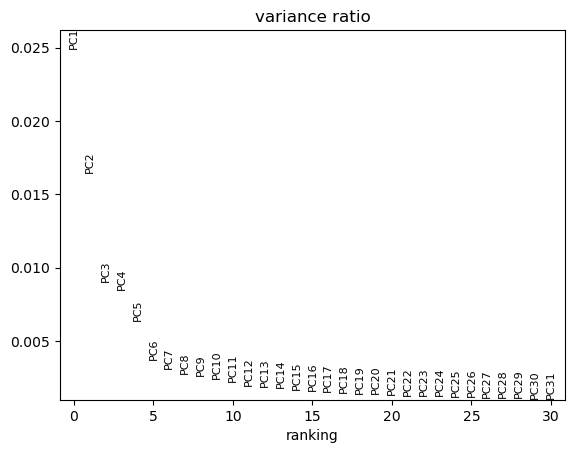

In [4]:
sc.pp.highly_variable_genes(merged_neu, n_top_genes=2000, batch_key="sample")
sc.pp.scale(merged_neu, max_value=10)
sc.tl.pca(merged_neu)
sc.pl.pca_variance_ratio(merged_neu)

In [5]:
# Harmony on PCs
hres = hm.run_harmony(merged_neu.obsm['X_pca'], merged_neu.obs, 'sample')
merged_neu.obsm['X_pca_harmony'] = hres.Z_corr.T

2025-09-17 14:33:23,799 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-09-17 14:33:26,540 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-09-17 14:33:26,617 - harmonypy - INFO - Iteration 1 of 10
2025-09-17 14:33:30,341 - harmonypy - INFO - Iteration 2 of 10
2025-09-17 14:33:34,058 - harmonypy - INFO - Converged after 2 iterations


In [6]:
merged_neu.obsm["X_pca_harmony_30"] = merged_neu.obsm["X_pca_harmony"][:, :30]
sc.pp.neighbors(merged_neu, use_rep="X_pca_harmony_30", n_neighbors=15)
sc.tl.umap(merged_neu, random_state=0)
sc.tl.leiden(merged_neu, resolution=0.3)

In [7]:
print("Layers:", list(merged_neu.layers.keys()))
has_log1p = "log1p" in merged_neu.layers
print("Has log1p layer?", has_log1p)
if has_log1p:
    A = merged_neu.layers["log1p"]
    # shape & nonzero entries
    shape = getattr(A, "shape", None)
    nnz = A.nnz if hasattr(A, "nnz") else int(np.count_nonzero(np.asarray(A)))
    # tiny peek to be sure it's not all zeros
    blk = A[:5, :5].toarray() if hasattr(A, "toarray") else np.asarray(A[:5, :5])
    print(f"log1p shape: {shape}, nnz: {nnz}, head-sum: {float(blk.sum())}")

Layers: ['X_detected', 'X_preNorm', 'X_scaled_normalised', 'counts', 'log1p']
Has log1p layer? True
log1p shape: (35065, 27429), nnz: 47703078, head-sum: 0.0


In [ ]:
merged_neu.write("../data/from_arnolda/h_neu.h5ad")

In [2]:
hdata = sc.read_h5ad('../data/from_arnolda/h_neu.h5ad')

Take a look at the UMAP first


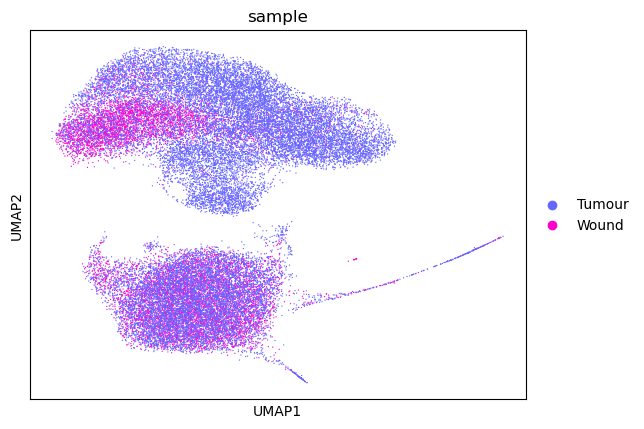

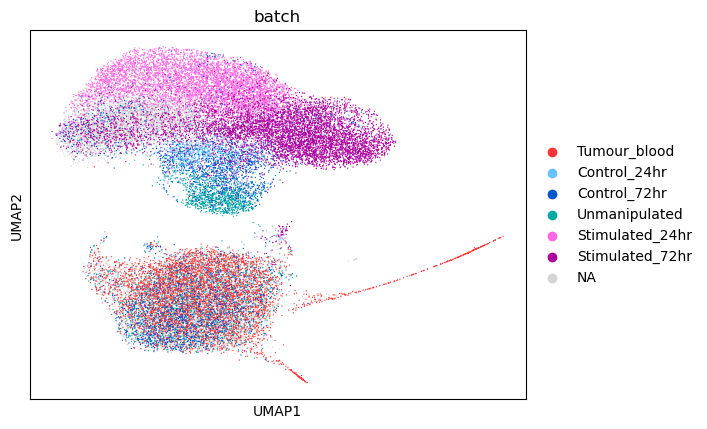

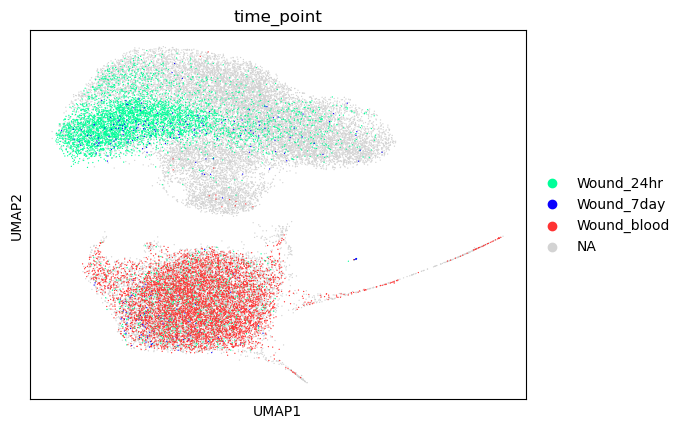

In [4]:
print("Take a look at the UMAP first")

palette_b = {
    "Control_24hr":     "#66C2FF",  # light electric blue
    "Control_72hr":     "#0055CC",  # strong royal blue
    "Stimulated_24hr":  "#FF66E5",  # light vivid magenta
    "Stimulated_72hr":  "#AD009F",  # deep magenta
    "Unmanipulated":    "#00A9A5",  # teal
    "Tumour_blood":     "#FF3333",  # bright scarlet red
}

palette_t = {"Wound_24hr": "#00FF99", "Wound_7day":"#0B01FE" , "Wound_blood": "#FF3333", "Other":  "#d3d3d3"}
palette_s = {"Tumour": "#6666FF", "Wound": "#FF00CC"}

sc.pl.umap(hdata, color= "sample", palette=palette_s)
sc.pl.umap(hdata, color= "batch", palette=palette_b)
sc.pl.umap(hdata, color= "time_point", palette=palette_t)

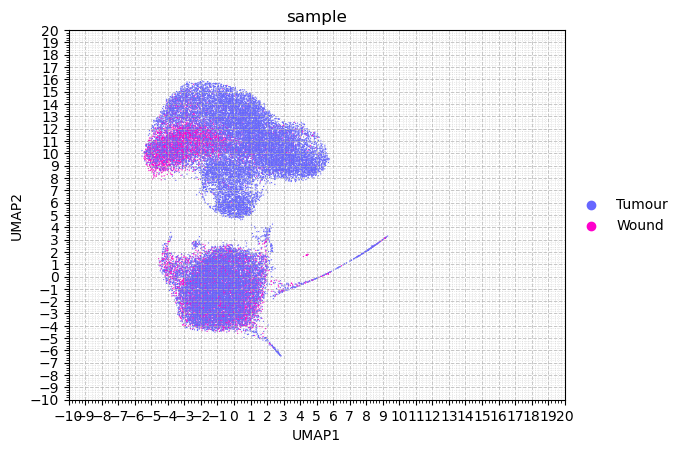

In [5]:
# Create the UMAP plot and capture the axis
ax = sc.pl.umap(
    hdata,
    color="sample",
    show=False,      # prevent auto-show
    return_fig=False # return the matplotlib axis instead of a figure
)

# Add gridlines
ax.grid(True, which='major', linestyle='--', linewidth=0.7, alpha=0.7)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.5)

# Set axis limits explicitly (adjust to your preferred range)
ax.set_xlim(-10, 20)
ax.set_ylim(-10, 20)

# Set tick marks (e.g. every 1 unit)
ax.set_xticks(range(-10, 21, 1))
ax.set_yticks(range(-10, 21, 1))

# Axis labels
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")

plt.show()

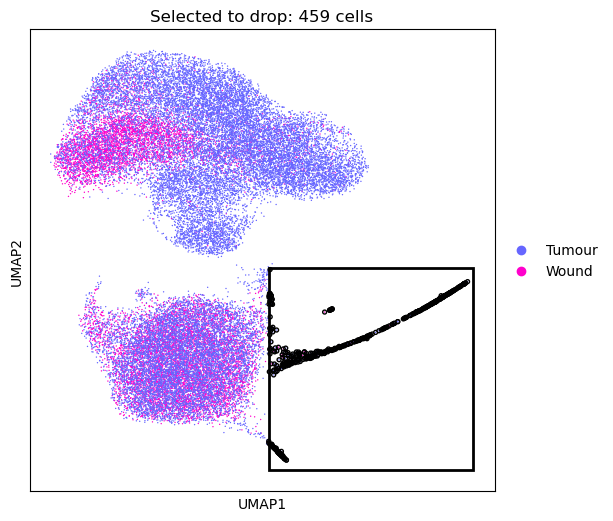

Removing cells: 459
Shapes: (35065, 27429) -> (34606, 27429)


In [6]:
from matplotlib.patches import Rectangle
A = hdata
# ---- 1) Rectangular gate around the pink-circled blob ----
XY = A.obsm["X_umap"][:, :2]
x, y = XY[:, 0], XY[:, 1]

# Bounds read off your plot (tweak slightly if you miss/overcatch a few points)
x0, x1 = 2.2, 9.5
y0, y1 =   -7, 4

rect_mask = (x >= x0) & (x <= x1) & (y >= y0) & (y <= y1)


to_drop = rect_mask

# ---- 2) Visual sanity check before removing ----
fig, ax = plt.subplots(figsize=(6, 6))
sc.pl.umap(A, color="sample", ax=ax, show=False, size=4)
ax.add_patch(Rectangle((x0, y0), x1-x0, y1-y0, fill=False, linewidth=2))
ax.scatter(x[to_drop], y[to_drop], s=8, facecolors='none', edgecolors='k')
ax.set_title(f"Selected to drop: {int(to_drop.sum())} cells")
plt.show()

# ---- 3) Drop & copy ----
print("Removing cells:", int(to_drop.sum()))
hdata = A[~to_drop].copy()
print("Shapes:", A.shape, "->", hdata.shape)

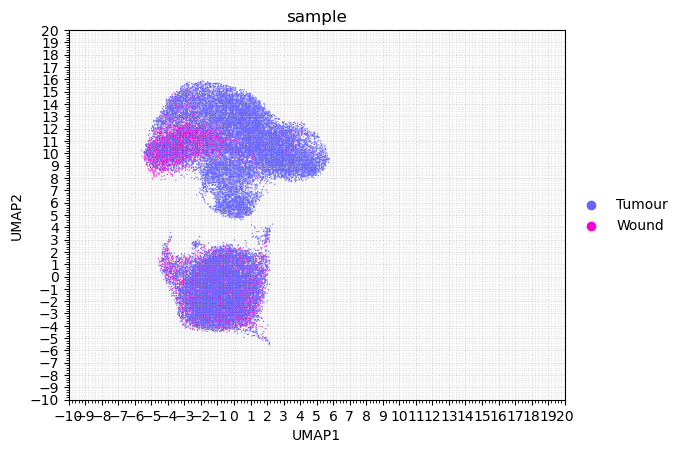

In [7]:
# Create the UMAP plot and capture the axis
ax = sc.pl.umap(
    hdata,
    color="sample",
    show=False,      # prevent auto-show
    return_fig=False # return the matplotlib axis instead of a figure
)

# Add gridlines
ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.5)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.5)

# Set axis limits explicitly (adjust to your preferred range)
ax.set_xlim(-10, 20)
ax.set_ylim(-10, 20)

# Set tick marks (e.g. every 1 unit)
ax.set_xticks(range(-10, 21, 1))
ax.set_yticks(range(-10, 21, 1))

# Axis labels
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")

plt.show()

In [8]:
# Eliminate weird cells (keep only cells inside your window)
# 1) Build masks for the two blobs
X = hdata.obsm["X_umap"]
x, y = X[:, 0], X[:, 1]

# Blob A: x ∈ [-5.0, 2.5], y ∈ [-6.0, 3.5]
mask_A = (x >= -5.0) & (x <= 2.5) & (y >= -6.0) & (y <= 3.5)

# Blob B: x ∈ [-6.0, 6.0], y ∈ [4.5, 16.0]
mask_B = (x >= -6.0) & (x <= 6.0) & (y >= 4.5) & (y <= 16.0)

# Union of both blobs
keep = mask_A | mask_B 

print(f"Keeping {int(keep.sum())} / {hdata.n_obs} cells "
      f"({100*keep.mean():.1f}%).  Dropping {hdata.n_obs - int(keep.sum())} outliers.")

# 2) Subset (UMAP coords are preserved for the kept cells)
idx = hdata.obs_names[keep]
hdata = hdata[idx].copy()

# (Optional) quick sanity on the kept range
Xk = hdata.obsm["X_umap"]
print("Kept UMAP x-range:", float(Xk[:,0].min()), "to", float(Xk[:,0].max()))
print("Kept UMAP y-range:", float(Xk[:,1].min()), "to", float(Xk[:,1].max()))

Keeping 34572 / 34606 cells (99.9%).  Dropping 34 outliers.
Kept UMAP x-range: -5.564077377319336 to 5.753481864929199
Kept UMAP y-range: -5.553464412689209 to 15.866390228271484


Take a look at the UMAP after removing weird cells


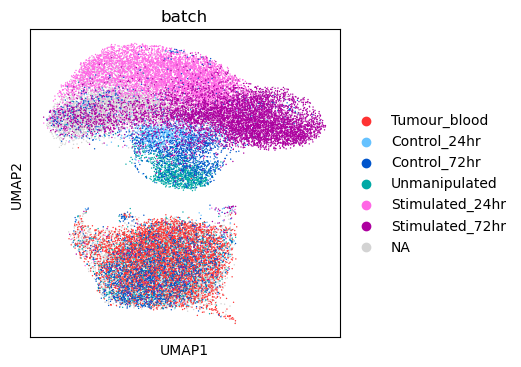

In [9]:
# 3) Look at the UMAP after removing weird cells (same layout, fewer points)
print("Take a look at the UMAP after removing weird cells")
fig, ax = plt.subplots(figsize=(4, 4))
sc.pl.umap(hdata, color="batch", ax=ax, show=False, frameon=True, size=4)
ax.set_xlabel("UMAP1"); ax.set_ylabel("UMAP2")
plt.show()

In [10]:
hdata.write("../data/from_arnolda/neu_trimmed.h5ad")

In [3]:
neu_trimmed = sc.read_h5ad('../data/from_arnolda/neu_trimmed.h5ad')

In [4]:
print("Samples:", neu_trimmed.obs["sample"].unique())
print("Batches:", neu_trimmed.obs["batch"].unique())
print("Time points:", neu_trimmed.obs["time_point"].unique())

Samples: ['Wound', 'Tumour']
Categories (2, object): ['Tumour', 'Wound']
Batches: [NaN, 'Control_24hr', 'Stimulated_24hr', 'Unmanipulated', 'Tumour_blood', 'Control_72hr', 'Stimulated_72hr']
Categories (6, object): ['Tumour_blood', 'Control_24hr', 'Control_72hr', 'Unmanipulated', 'Stimulated_24hr', 'Stimulated_72hr']
Time points: ['Wound_24hr', 'Wound_7day', 'Wound_blood', NaN]
Categories (3, object): ['Wound_24hr', 'Wound_7day', 'Wound_blood']


In [5]:
# Ensure categoricals
for col in ["batch", "time_point"]:
    if not pd.api.types.is_categorical_dtype(neu_trimmed.obs[col]):
        neu_trimmed.obs[col] = neu_trimmed.obs[col].astype("category")

# Add "Other" category where needed
for col in ["batch", "time_point"]:
    if "Other" not in neu_trimmed.obs[col].cat.categories:
        neu_trimmed.obs[col] = neu_trimmed.obs[col].cat.add_categories(["Other"])

# 1) In Wound samples, batch is N/A -> set to "Other"
mask_wound_batch_na = (neu_trimmed.obs["sample"] == "Wound") & (neu_trimmed.obs["batch"].isna())
neu_trimmed.obs.loc[mask_wound_batch_na, "batch"] = "Other"

# 2) In Tumour samples, time_point is N/A -> set to "Other"
mask_tumour_tp_na = (neu_trimmed.obs["sample"] == "Tumour") & (neu_trimmed.obs["time_point"].isna())
neu_trimmed.obs.loc[mask_tumour_tp_na, "time_point"] = "Other"

# Optional: set category orders (put Other last)
neu_trimmed.obs["batch"] = neu_trimmed.obs["batch"].cat.set_categories(
    ["Tumour_blood","Control_24hr","Control_72hr","Unmanipulated","Stimulated_24hr","Stimulated_72hr","Other"],
    ordered=True
)
neu_trimmed.obs["time_point"] = neu_trimmed.obs["time_point"].cat.set_categories(
    ["Wound_blood","Wound_24hr","Wound_7day","Other"],
    ordered=True
)

# Clear cached color maps so legend updates
for k in ["batch_colors", "time_point_colors"]:
    if k in neu_trimmed.uns:
        del neu_trimmed.uns[k]


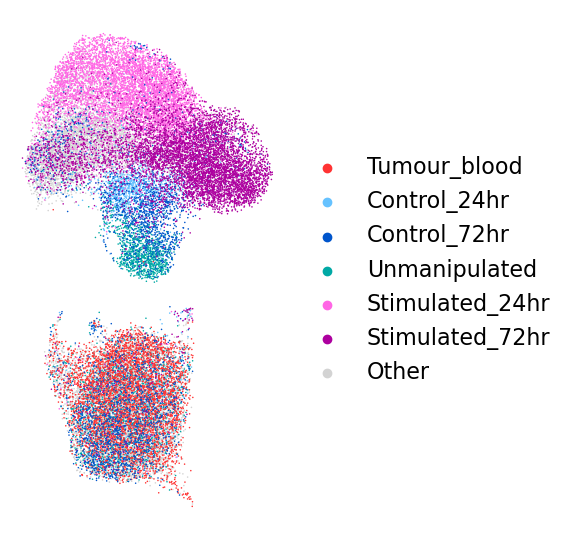

In [13]:
palette_map = {
    "Control_24hr":     "#66C2FF",  # light electric blue
    "Control_72hr":     "#0055CC",  # strong royal blue
    "Stimulated_24hr":  "#FF66E5",  # light vivid magenta
    "Stimulated_72hr":  "#AD009F",  # deep magenta
    "Unmanipulated":    "#00A9A5",  # teal
    "Tumour_blood":     "#FF3333",
    "Other":  "#d3d3d3",
}
# Plot
fig, ax = plt.subplots(figsize=(5.5, 5.5))
sc.pl.umap(
    neu_trimmed,
    color="batch",
    palette=palette_map,
    ax=ax,
    #na_color=fallback,
    na_in_legend=True,
    legend_fontsize=16,
    legend_fontoutline=2,
    add_outline=False,
    size=5,
    title="",
    show=False,
)

ax.set(xlabel="", ylabel="")
ax.set_axis_off()
ax.set_aspect(1.0)
fig.tight_layout()
plt.show()

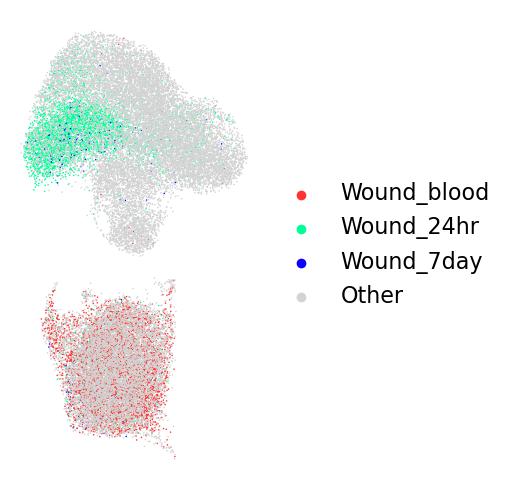

In [11]:
palette_map = {"Wound_24hr": "#00FF99", "Wound_7day":"#0B01FE" , "Wound_blood": "#FF3333", "Other":  "#d3d3d3"} 

fig, ax = plt.subplots(figsize=(5, 5))
sc.pl.umap(
    neu_trimmed,
    color="time_point",
    palette=palette_map,
    ax=ax,
    #na_color="lightgrey",
    na_in_legend=True,
    legend_fontsize=16,
    legend_fontoutline=2,
    add_outline=False,
    size=5,
    title="",
    show=False,
)

ax.set(xlabel="", ylabel="")
ax.set_axis_off()
ax.set_aspect(1.0)
fig.tight_layout()
plt.show()

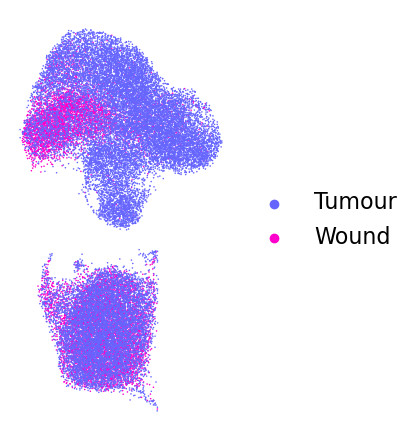

In [14]:
palette_map = {"Tumour": "#6666FF", "Wound": "#FF00CC"}

fig, ax = plt.subplots(figsize=(4.5, 4.5))
sc.pl.umap(
    neu_trimmed,
    color="sample",
    palette=palette_map,     # <--- force custom colors
    ax=ax,
    na_color="lightgrey",
    na_in_legend=True,
    legend_fontsize=16,
    legend_fontoutline=2,
    add_outline=False,
    size=5,
    title="",
    show=False,
    
)

ax.set(xlabel="", ylabel="")
ax.set_axis_off()
ax.set_aspect(1.0)
fig.tight_layout()
plt.show()

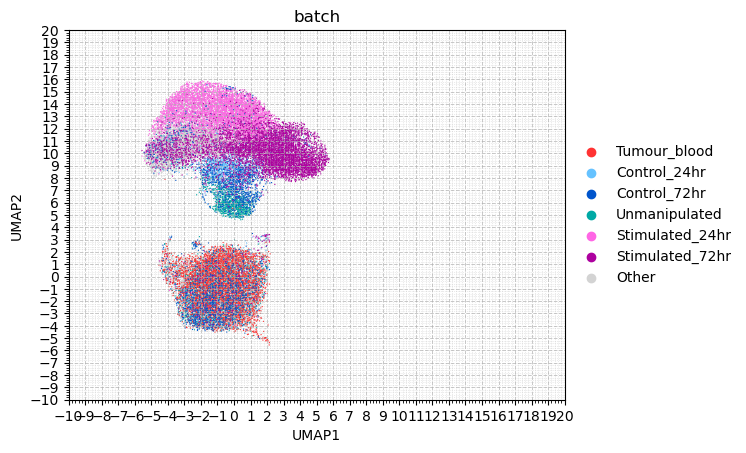

In [34]:
# Create the UMAP plot and capture the axis
ax = sc.pl.umap(
     neu_trimmed,
    color="batch",
    show=False,      # prevent auto-show
    return_fig=False # return the matplotlib axis instead of a figure
)

# Add gridlines
ax.grid(True, which='major', linestyle='--', linewidth=0.7, alpha=0.7)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.5)

# Set axis limits explicitly (adjust to your preferred range)
ax.set_xlim(-10, 20)
ax.set_ylim(-10, 20)

# Set tick marks (e.g. every 1 unit)
ax.set_xticks(range(-10, 21, 1))
ax.set_yticks(range(-10, 21, 1))

# Axis labels
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")

plt.show()

blob
Blob_up     20353
Blob_low    14219
Name: count, dtype: int64


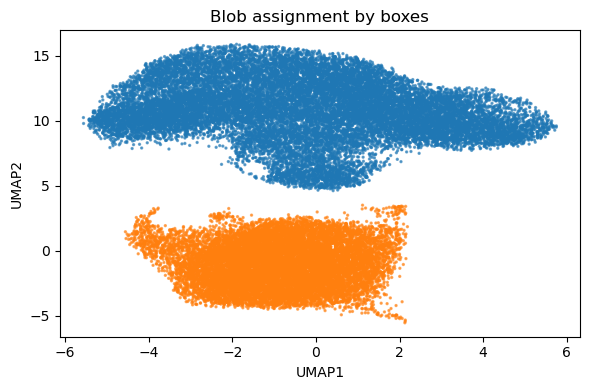

In [36]:
from matplotlib.patches import Rectangle

adata = neu_trimmed  # or your object

# --- 1) Build blob labels from coordinate boxes ---
X = adata.obsm["X_umap"]
x, y = X[:,0], X[:,1]

# Your boxes:
# Blob 0: x ∈ [-5.0, 2.5],  y ∈ [-6, 3.5]
# Blob 1: x ∈ [-6.0, 6.0],  y ∈ [4.5,16.0]
b0 = (x >= -5.0)  & (x <= 2.5) & (y >= -6) & (y <= 3.5)
b1 = (x >= -6.0) & (x <= 6.6)  & (y >= 4.4) & (y <= 16.0)

# Note: a few points might fall in both boxes (overlap 7.2–8.8 in x, 2–7 in y).
# We'll resolve ties by assigning to the *closest rectangle center*.
# Anything outside both becomes "Other".
blob = np.array(["Other"] * adata.n_obs, dtype=object)

# initial assignment
blob[b0 & ~b1] = "Blob_low"   # your "blob 0"
blob[b1 & ~b0] = "Blob_up"  # your "blob 1"

# resolve overlaps by distance to box centers
overlap = b0 & b1
if overlap.any():
    c0 = np.array([(-5.0 + 2.5)/2, (-6 + 3.5)/2])     # center of blob 0 box
    c1 = np.array([(-6.0 + 6.0)/2, (4.5 + 16.0)/2])     # center of blob 1 box
    d0 = np.sqrt((x[overlap]-c0[0])**2 + (y[overlap]-c0[1])**2)
    d1 = np.sqrt((x[overlap]-c1[0])**2 + (y[overlap]-c1[1])**2)
    blob[overlap] = np.where(d0 <= d1, "Blob_low", "Blob_up")

adata.obs["blob"] = pd.Categorical(blob, categories=[ "Blob_low", "Blob_up"])

# Quick sanity print
print(adata.obs["blob"].value_counts(dropna=False))

# --- 2) (Optional) Quick visual check with rectangles ---
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x, y, s=2, c=adata.obs["blob"].map({"Blob_low":"tab:orange","Blob_up":"tab:blue","Other":"lightgrey"}), alpha=0.6)
#ax.add_patch(Rectangle((-1,-3), 8.8-(-1), 7-(-3), fill=False, lw=2))     # blob 0 box
#ax.add_patch(Rectangle((7.2,2), 19-7.2, 14-2, fill=False, lw=2))         # blob 1 box
ax.set_xlabel("UMAP1"); ax.set_ylabel("UMAP2"); ax.set_title("Blob assignment by boxes")
plt.tight_layout(); plt.show()


In [37]:
# --- 3) Helper to compute counts + row-fractions ---
def counts_and_fractions(adata, by_col, blobs=("Blob_low","Blob_up")):
    # Make sure column exists
    assert by_col in adata.obs.columns, f"Missing obs['{by_col}']"
    # get full category set in stable order
    if pd.api.types.is_categorical_dtype(adata.obs[by_col]):
        cats = list(adata.obs[by_col].cat.categories)
    else:
        cats = sorted(pd.unique(adata.obs[by_col].astype(str)))
    counts = (pd.crosstab(adata.obs["blob"], adata.obs[by_col])
                .reindex(index=blobs, columns=cats, fill_value=0))
    fracs = counts.div(counts.sum(axis=1).replace(0, np.nan), axis=0)
    return counts, fracs

In [38]:
# --- 4) Your three summaries ---
sample_counts, sample_fracs = counts_and_fractions(adata, "sample")
tp_counts,     tp_fracs     = counts_and_fractions(adata, "time_point")
batch_counts,  batch_fracs  = counts_and_fractions(adata, "batch")

print("\nCounts: blob × sample\n", sample_counts)
print("\nFractions (%): blob × sample\n", (sample_fracs*100).round(1))

print("\nCounts: blob × time_point\n", tp_counts)
print("\nFractions (%): blob × time_point\n", (tp_fracs*100).round(1))

print("\nCounts: blob × batch\n", batch_counts)
print("\nFractions (%): blob × batch\n", (batch_fracs*100).round(1))


Counts: blob × sample
 sample    Tumour  Wound
blob                   
Blob_low    7952   6267
Blob_up    15697   4656

Fractions (%): blob × sample
 sample    Tumour  Wound
blob                   
Blob_low    55.9   44.1
Blob_up     77.1   22.9

Counts: blob × time_point
 time_point  Wound_blood  Wound_24hr  Wound_7day  Other
blob                                                  
Blob_low           5324         836         107   7952
Blob_up              14        4489         153  15697

Fractions (%): blob × time_point
 time_point  Wound_blood  Wound_24hr  Wound_7day  Other
blob                                                  
Blob_low           37.4         5.9         0.8   55.9
Blob_up             0.1        22.1         0.8   77.1

Counts: blob × batch
 batch     Tumour_blood  Control_24hr  Control_72hr  Unmanipulated  \
blob                                                                
Blob_low          4539           452          1432           1283   
Blob_up             

In [39]:
# Rename blob categories
adata.obs["blob"] = adata.obs["blob"].cat.rename_categories({
    "Blob_low": "Blood-like",
    "Blob_up": "Effector",
    
})

# Sanity check
print(adata.obs["blob"].value_counts())

blob
Effector      20353
Blood-like    14219
Name: count, dtype: int64


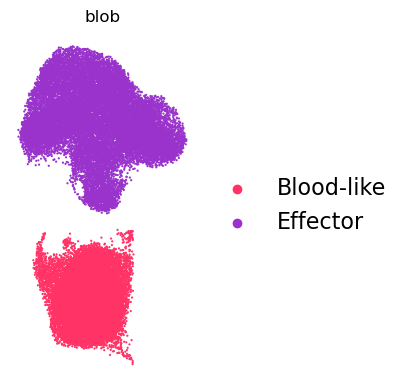

In [42]:
fig, ax = plt.subplots(figsize=(4, 4))
sc.pl.umap(
    neu_trimmed,
    color="blob",
    palette={
        "Blood-like": "#FF3366",
        "Effector": "#9933CC",
    },
    ax=ax,
    #na_color=fallback,
    na_in_legend=True,
    legend_fontsize=16,
    legend_fontoutline=2,
    add_outline=False,
    size=10,
    show=False,
)

ax.set(xlabel="", ylabel="")
ax.set_axis_off()
ax.set_aspect(1.0)
fig.tight_layout()
plt.show()

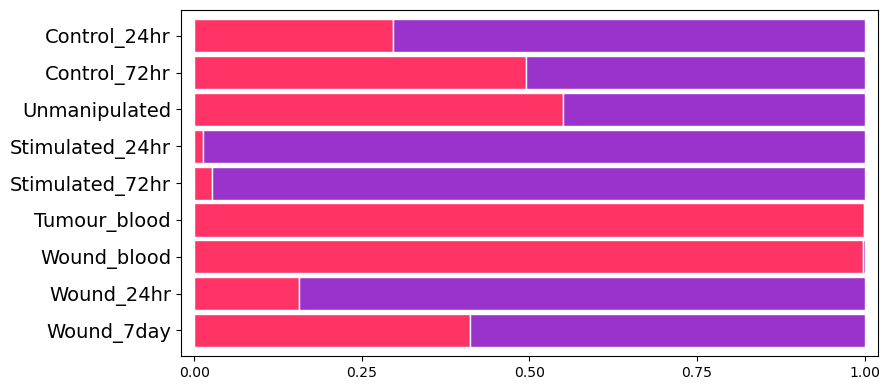

In [44]:
# Step 1: Define the raw data
data = {
   
    "Blood_like": {"Control_24hr":452 , "Control_72hr":1432, "Unmanipulated":1283,
                    "Stimulated_24hr":77 , "Stimulated_72hr":169, "Tumour_blood":4539,
                   "Wound_blood": 5324, "Wound_24hr": 836, "Wound_7day": 107},
     "Effector": {"Control_24hr":1068, "Control_72hr":1459 , "Unmanipulated":1049,
                  "Stimulated_24hr":6070, "Stimulated_72hr":6047, "Tumour_blood":4,
                  "Wound_blood": 14, "Wound_24hr": 4489, "Wound_7day": 153}
}

order = ["Control_24hr","Control_72hr","Unmanipulated",
         "Stimulated_24hr","Stimulated_72hr","Tumour_blood",
         "Wound_blood","Wound_24hr","Wound_7day"]

# Build DF in your desired row order
df = pd.DataFrame(data).reindex(order)

# (optional) also fix column order to match your colors
col_order = ["Blood_like", "Effector"]
fractions = df[col_order].div(df.sum(axis=1), axis=0)

ax = fractions.plot(
    kind="barh", stacked=True, figsize=(9,4), width=0.9, edgecolor="white",
    color=["#FF3366","#9933CC"]  # Blood_like, Effector
)

# Put the first row at the TOP
ax.invert_yaxis()

# Step 5: Style 
ax.set_xlim(0, 1) 
ax.set_xticks([0.0, 0.25, 0.5, 0.75, 1.0]) 
ax.set_xticklabels(['0.00', '0.25', '0.50', '0.75', '1.00']) 
ax.set_xlim(-0.02, 1.02)
ax.tick_params(axis='y', labelsize=14) 
# Clean layout 
ax.set_xlabel('')
ax.set_ylabel('') 
ax.set_title('') 
ax.legend().remove() 
plt.tight_layout() 
plt.show()

In [45]:
adata.write("../data/merged_neu_with_blob.h5ad")